In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Layer, Input
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Concatenate, UpSampling2D
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
listDir = []
for dir in os.listdir(path):
    if dir != "classes.json":
        listDir.append(dir)

listDir = sorted(listDir)

In [3]:
def loadImg(path, dirTile):
    input_img, mask_img = [], []
    path = os.path.join(path, dirTile)
    inpDir, maskDir = os.listdir(path)
    
    imgDirs = sorted(os.listdir(os.path.join(path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(path, maskDir)))
    
    for imgDir in imgDirs:
        imgDir = os.path.join(path, inpDir, imgDir)
        img = load_img(imgDir, target_size = (224, 224))
        img = tf.convert_to_tensor(img, dtype = tf.float32) / 255.0
        input_img.append(img)
    
    for mask_imgDir in mask_imgDirs:
        mask_imgDir = os.path.join(path, maskDir, mask_imgDir)
        mask = load_img(mask_imgDir, target_size = (224, 224))
        mask = tf.convert_to_tensor(mask, dtype = tf.float32) / 255.0
        mask_img.append(mask)
    
    return input_img, mask_img

In [4]:
def loadData(path = path, listDir = listDir):
    imgs_data, masks_data = [], []
    for dirTile in listDir:
        input_imgs, mask_imgs = loadImg(path, dirTile)
        
        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)
    return imgs_data, masks_data

In [5]:
input_imgs, mask_imgs = loadData()

(-0.5, 223.5, 223.5, -0.5)

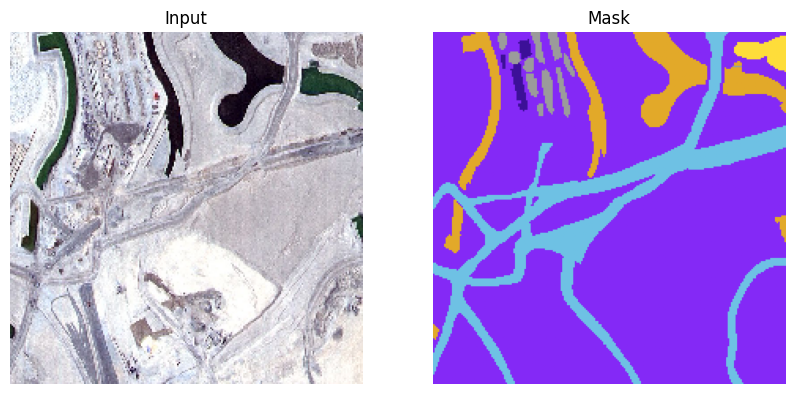

In [6]:
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(input_imgs[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_imgs[0])
plt.axis("off")

In [7]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_masks, test_masks = train_test_split(input_imgs, mask_imgs, 
                                                                  test_size = 0.2, 
                                                                  shuffle = True, 
                                                                  random_state = 42)

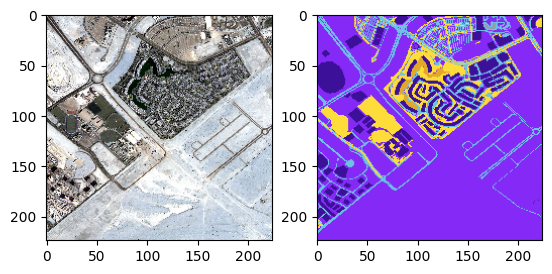

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[1])

plt.subplot(1, 2, 2)
plt.imshow(train_masks[1])

In [9]:
train_data = np.array(list(zip(train_imgs, train_masks)))
test_data = np.array(list(zip(test_imgs, test_masks)))

In [10]:
def Conv(x, dropout, filters):
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = Dropout(dropout)(x)
  pool = MaxPooling2D(pool_size = (2, 2))(x)

  return x, pool

def UpSample(x, skip_connect, dropout, filters):
  x = Concatenate(axis = -1)([skip_connect, UpSampling2D(size = (2, 2))(x)])
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = Dropout(dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)

  return x

In [11]:
def UNet(x, dropout, conv = [32, 64, 128, 256, 512]):

  # encoder
  conv1, pool1 = Conv(x, dropout, conv[0]) # 224 -> 112
  conv2, pool2 = Conv(pool1, dropout, conv[1]) # 112 -> 56
  conv3, pool3 = Conv(pool2, dropout, conv[2]) # 56 -> 28
  conv4, pool4 = Conv(pool3, dropout, conv[3]) # 28 -> 14

  conv5 = Conv2D(filters = conv[4], kernel_size = 3, padding = 'same', activation = 'relu')(pool4)
  conv5 = Dropout(dropout)(conv5)
  conv5 = BatchNormalization()(conv5)

  # decoder
  conv6 = UpSample(conv5, conv4, dropout, conv[4]) # 14 -> 28
  conv7 = UpSample(conv6, conv3, dropout, conv[3]) # 28 -> 56
  conv8 = UpSample(conv7, conv2, dropout, conv[2]) # 56 -> 112
  conv9 = UpSample(conv8, conv1, dropout, conv[1]) # 112 -> 224

  # output
  result = Conv2D(filters = 3, kernel_size = 1, padding = 'same', activation = 'sigmoid')(conv9)

  return result

In [12]:
input = Input(shape = (224, 224, 3))
output = UNet(input, dropout = 0.1)

model = Model(inputs = input, outputs = output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 56, 56, 128)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 10,970,083 (41.85 MB)

 Trainable params: 10,966,179 (41.83 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [13]:
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [16]:
history = model.fit(np.array(train_imgs), np.array(train_masks),
                    batch_size = 8, 
                    epochs = 10, 
                    validation_data = (np.array(test_imgs), np.array(test_masks)))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 15s/step - accuracy: 0.8803 - loss: 0.5644 - val_accuracy: 0.7488 - val_loss: 7.6507
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 15s/step - accuracy: 0.8651 - loss: 0.5608 - val_accuracy: 0.7486 - val_loss: 4.7887
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - accuracy: 0.8697 - loss: 0.5619 - val_accuracy: 0.7446 - val_loss: 4.0517
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 15s/step - accuracy: 0.8433 - loss: 0.5675 - val_accuracy: 0.7470 - val_loss: 1.6261
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 15s/step - accuracy: 0.8720 - loss: 0.5559 - val_accuracy: 0.7974 - val_loss: 0.8597
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 15s/step - accuracy: 0.9002 - loss: 0.5454 - val_accuracy: 0.7883 - val_loss: 0.6347
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 15s/step - accuracy: 0.8646 - loss: 0.5564 - val_accuracy: 0.8263 - val_loss: 0.7199
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 15s/step - accuracy: 0.8838 - loss: 0.5586 - val_accuracy: 0.8131 - val_loss:

<ipython-input-17-bcb846c293af>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


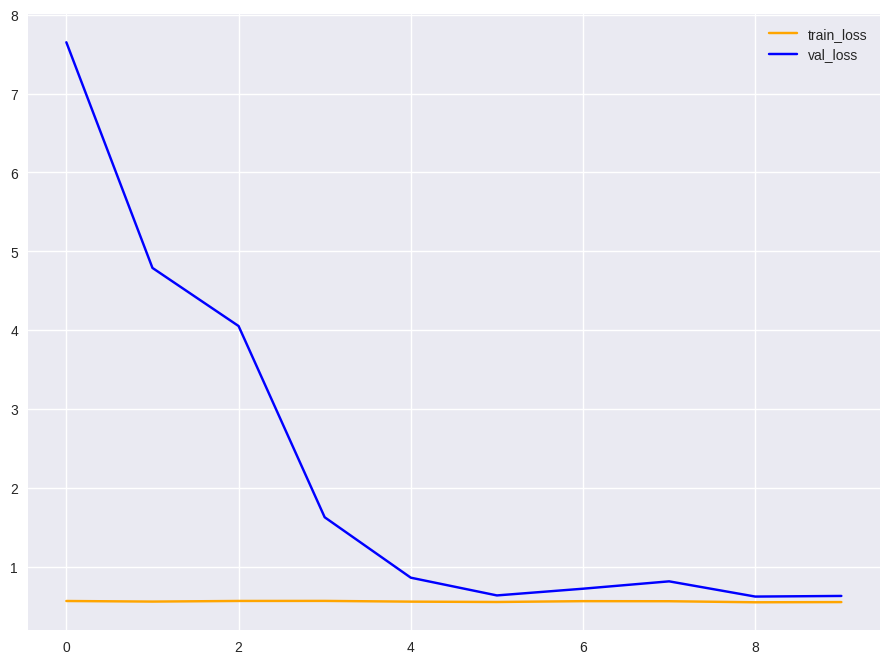

<ipython-input-17-bcb846c293af>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


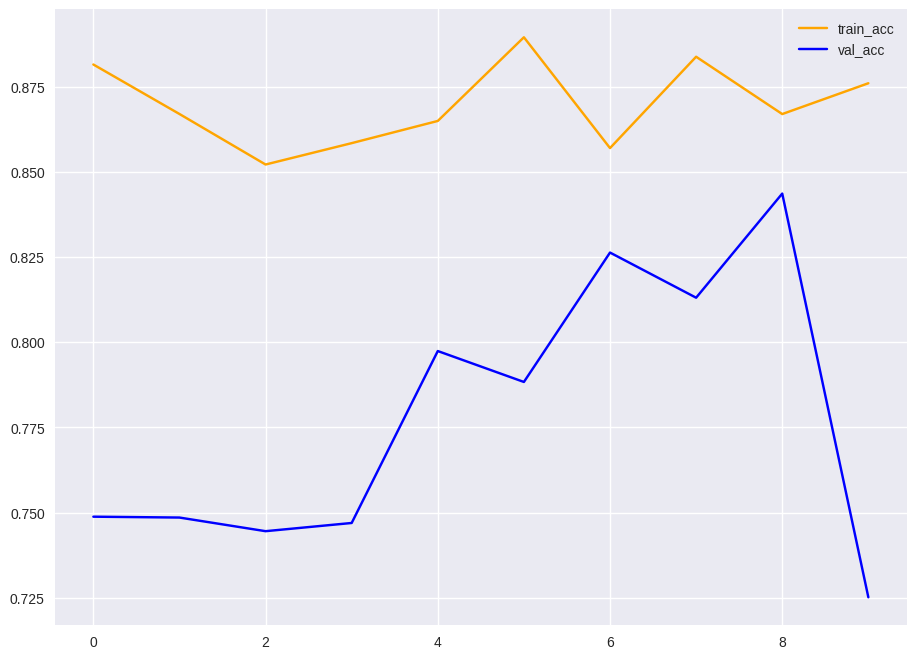

In [17]:
plt.subplot(1,2,1)
plt.style.use('seaborn')
plt.figure(figsize = (11, 8))
plt.plot(history.history['loss'], c = 'orange', label = 'train_loss')
plt.plot(history.history['val_loss'], c = 'blue', label = 'val_loss')
plt.legend()
plt.show()

plt.subplot(1,2,2)
plt.style.use('seaborn')
plt.figure(figsize = (11, 8))
plt.plot(history.history['accuracy'], c = 'orange', label = 'train_acc')
plt.plot(history.history['val_accuracy'], c = 'blue', label = 'val_acc')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


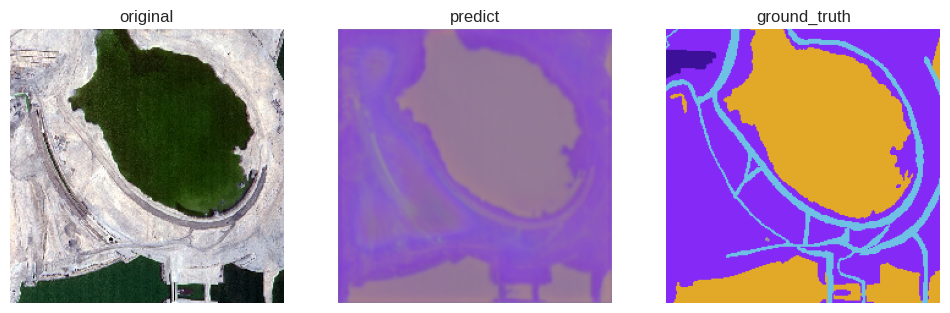

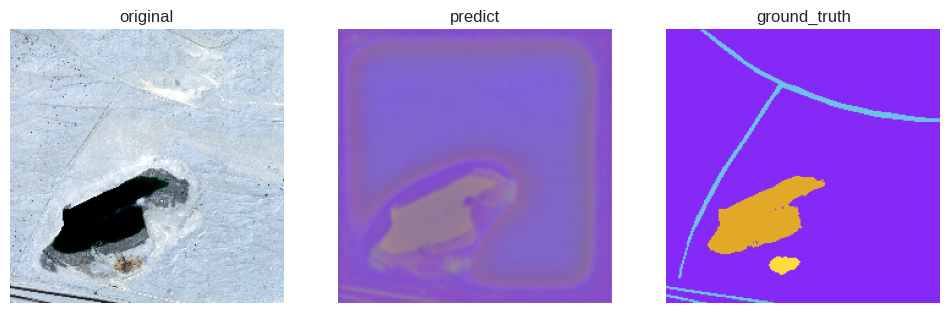

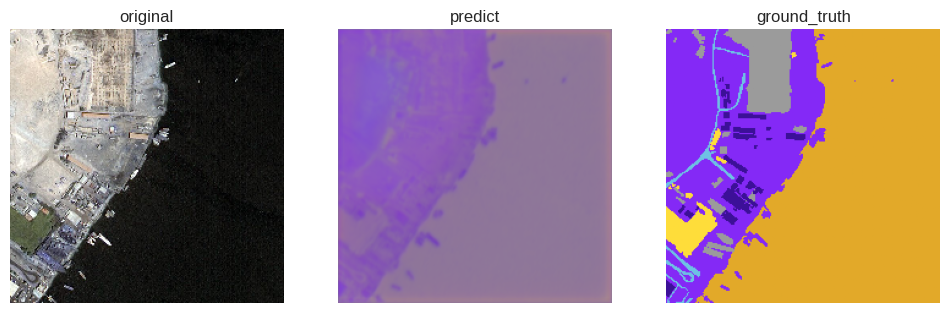

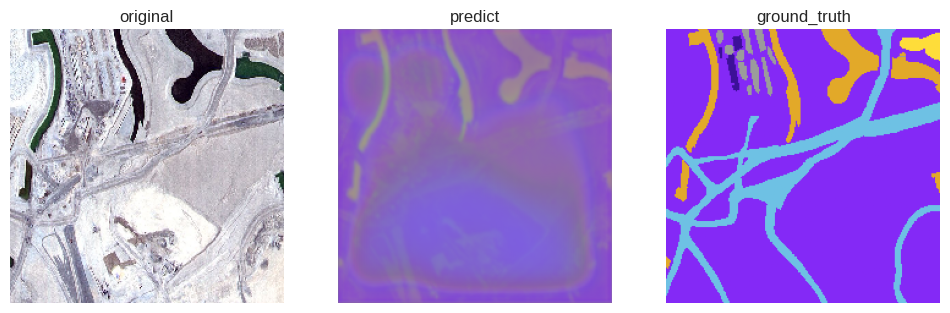

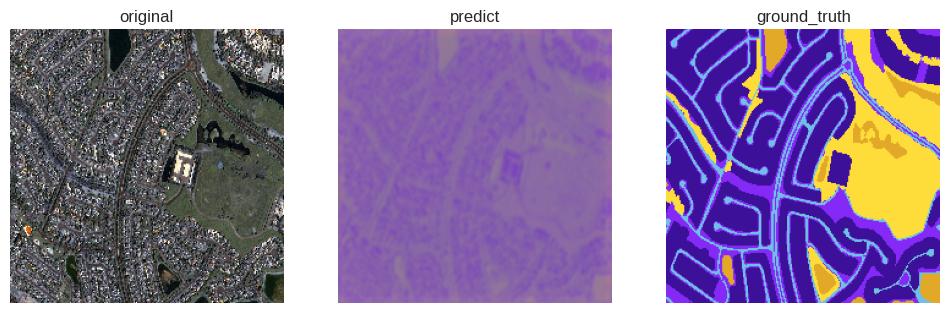

In [19]:
images_predict = model.predict(np.array(test_imgs))
def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize = (12, 7))
    
    ax[0].set_title('original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")
    
    ax[1].set_title('predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")
    
    ax[2].set_title('ground_truth')
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

for id in range(5):
    show_result(id)